# LSTMs for Chaotic Dynamics

### Authors: Elise Özalp (elise.ozalp@imperial.ac.uk), Luca Magri (luca.magri@imperial.ac.uk)

## Introduction

This notebook explores the application of Long Short-Term Memory (LSTM) networks in learning chaotic dynamics and their stability properties, focusing on the Lorenz-63 system. Chaotic systems like Lorenz-63 exhibit complex behavior, making them challenging for modeling. We discuss the training process, model evaluation, and the interpretability of LSTM predictions in the context of chaotic systems. The results obtained provide valuable insights into the potential of deep learning models for understanding and predicting chaotic behavior.


## Lorenz-63 System

The Lorenz-63 system is a set of ordinary differential equations that describe a simplified atmospheric convection model. It is a classic example of a chaotic system, characterized by sensitive dependence on initial conditions. In this notebook, we delve into the dynamics of the Lorenz-63 system and discuss the challenges of capturing its chaotic nature.

## LSTMs and Chaotic Dynamics

Long Short-Term Memory networks, a type of recurrent neural network (RNN), have shown promise in capturing intricate temporal dependencies in sequential data. We explore how LSTMs can be applied to learn and predict the chaotic behavior inherent in systems like Lorenz-63. Through this analysis, we aim to gain insights into the capabilities and limitations of LSTMs in handling chaotic dynamics.

## Learning Chaotic Dynamics from Data

The core focus of this notebook is on utilizing LSTMs to learn chaotic dynamics from data generated by the Lorenz-63 system. 
Feel free to adapt and expand upon this structure to suit the specific details and findings of your analysis. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchinfo
import scipy.stats as stats 
from mpl_toolkits.mplot3d import Axes3D
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# 

## Lorenz-63 System

The Lorenz-63 system is a set of ordinary differential equations that describe a simplified atmospheric convection model. It is a classic example of a chaotic system, characterized by sensitive dependence on initial conditions. In this notebook, we delve into the dynamics of the Lorenz-63 system and discuss the challenges of capturing its chaotic nature.

The system is given by 

\begin{align*}
\frac{dx}{dt} &= \sigma \cdot (y - x) \\
\frac{dy}{dt} &= x \cdot (\rho - z) - y \\
\frac{dz}{dt} &= x \cdot y - \beta \cdot z
\end{align*}


where  x, y, z are the state variables and $\beta$, $\rho $, and  $\sigma $ are system parameters. For $\beta = \frac{8}{3}, \rho =28, \sigma = 10$, the system exhibits chaotic behaviour. We select the initial condition $\begin{bmatrix} x(0); y(0); z(0) \end{bmatrix} = \begin{bmatrix} 0; 1; 1 \end{bmatrix}$. For this system, the largest Lyapunov exponent is given by $\lambda\approx 0.9$.

### Generating the data:
We solve the system using RK45, remove an initial transient and then normalize the input between $\begin{bmatrix}-1, 1\end{bmatrix}$ (for better training).

In [2]:
def lorenz63(u, params):
    beta, rho, sigma = params
    x, y, z = u
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

def RK4(ddt, u0, T, params):
    u = np.empty((T.size, u0.size))
    u[0] = u0
    der = np.empty((T.size, u0.size))
    for i in range(1, T.size):
        delta_t = (T[i] - T[i-1])
        K1 = ddt(u[i-1], params)
        K2 = ddt(u[i-1] + delta_t*K1/2.0, params)
        K3 = ddt(u[i-1] + delta_t*K2/2.0, params)
        K4 = ddt(u[i-1] + delta_t*K3, params)
        u[i:] = u[i-1] + np.array(delta_t * (K1/2.0 + K2 + K3 + K4/2.0) / 3.0)
        der[i-1] = K1
    return u, der


def solve_rk4(function, N, dt, u0, params):
    T = np.arange(N+1) * dt
    U, rhs = RK4(function, u0, T, params)
    return T, U, rhs


def split_data(U, train_size, valid_size, test_size):
    return U[:train_size], U[train_size: train_size + valid_size],  U[train_size + valid_size : train_size + valid_size+test_size]

In [3]:
def qr_factorization(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = A[:, j].copy()

        for i in range(j):
            q = Q[:, i]
            R[i, j] = q.dot(v)
            v = v - R[i, j] * q

        norm = np.linalg.norm(v)
        Q[:, j] = v / norm
        R[j, j] = norm
    return Q, R


def solve_ode_LEs(system, N, Ntherm, dt, u0, params, norm_time=1, dim=3):
    """
        Solves the ODEs for N time steps starting from u0.
        Additionally it computes the Lyapunov spectrum and CLVs
        Returned values are normalized.

        Args:
            system: str that defines the dynamical system
            N: number of time steps
            N: number of time steps in test set
            dt: timestep
            u0: initial condition
            saveclvs: flag to select if to save full CLVs or do a consistency check
            norm: normalisation factor of u0 (None if not normalised)
            params: parameters for ODE
        Returns:
            normalized time series of shape (N+1, u0.size)
    """
        
    
    print('Dynamical system:',system)
    N_test = N - Ntherm
    print('Number of timesteps',N)
    print('Number of timesteps in test',N_test)
    print('norm_time:',norm_time)
    
        
    T = np.arange(N+1) * dt
    #T = np.arange(N) * dt
    Ttest = np.arange(1,int((N_test)/norm_time)+1) * dt * norm_time
    xt = u0
    U = np.empty((T.size, u0.size))
    U[0] = u0
    
    N_test_norm = int(N_test/norm_time)
    
    # Lyapunov Exponents timeseries
    LE   = np.zeros((N_test_norm,dim))
    # Instantaneous Lyapunov Exponents timeseries
    IBLE   = np.zeros((N_test_norm,dim))
    # Q matrix recorded in time
    QQ_t = np.zeros((dim,dim,N_test_norm))
    # R matrix recorded in time
    RR_t = np.zeros((dim,dim,N_test_norm))
    
    #set random orthonormal Lyapunov vectors 
    delta = scipy.linalg.orth(np.random.rand(dim,dim))#np.eye(D)    
    Q, R = qr_factorization(delta)
    delta = Q[:,:dim]    
    
    indx = 0
    for i in range(1, T.size):
        #xn, Mtemp = RK4varb(ddt, xt, dt, params, delta)        
        xn, Mtemp = RK4var(F_all, eom, jac, xt, dt, params, delta)        
        xt += xn
        delta += Mtemp             

        if i%norm_time==0:            
            Q, R = qr_factorization(delta)
            delta = Q[:,:dim]
            if i > Ntherm:                
                QQ_t[:,:,indx] = Q
                RR_t[:,:,indx] = R
                LE[indx]       = np.abs(np.diag(R))
                Jacobian       = jac(xt, params)
                for j in range(dim):
                    IBLE[indx, j] = np.dot(Q[:,j].T, np.dot(Jacobian,Q[:,j]))
                indx += 1

        U[i] = xt
    
    LEs = np.cumsum(np.log(LE[:]),axis=0) / np.tile(Ttest[:],(dim,1)).T
    print('LEs', LEs[0],'LEs-1', LEs[-1], 'Ttest[0]', Ttest[0], 'Ttest[-1]', Ttest[-1], 'indx', indx )
    print('RR0', np.diag(RR_t[:,:,0]),'RR-1',np.diag(RR_t[:,:,-1]))
    print('IBLE', IBLE[0],'IBLE-1', IBLE[-1])

    return U, LEs

In [4]:
dim = 3
params = [2.667, 28, 10]  # beta, rho, sigma
u0 = np.array([0.0, 1.0, 1.0])  # initial condition

dt = 0.01  # time step
t_lyap = 0.9**(-1)  # Lyapunov time

N_lyap = int(t_lyap/dt)
N_trans = 2000  # initial transient to discard
N_total = 500*N_lyap + N_trans
time_array, U_rk4, derU = solve_rk4(lorenz63, N_total, dt, u0=u0, params=params)
time_array = time_array[N_trans:]
U_rk4 = U_rk4[N_trans:].astype(np.float32)
U_rk4 = U_rk4/np.max(U_rk4, axis=0)  # remove the initial transient
time_array_lyap = np.arange(0, len(time_array), step=dt)/0.09
print(f" Shape of solution generated with RK45: {U_rk4.shape}")

 Shape of solution generated with RK45: (55501, 3)


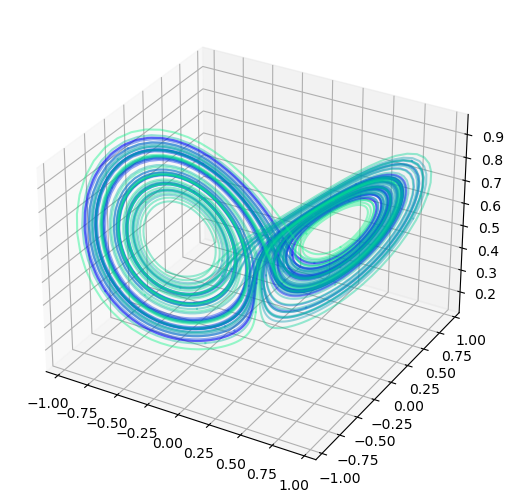

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
n = len(U_rk4[:10000])
s = 100
cmap = plt.cm.winter  # winter
cmap_2 = plt.cm.autumn  # autumn

for i in range(0, n - s, s):
    ax.plot(U_rk4[i:i+s+1, 0], U_rk4[i:i+s+1, 1], U_rk4[i:i+s+1, 2], color=cmap(i/n), alpha=0.4)

plt.show()


# 

## Preparing the data for training 


#### 1. Splitting Data
- Divide the dataset into three sets: training, testing, and validation data.

#### 2. Time Window for LSTM
- The LSTM takes data of the following input shape (batch size, window size, dimension of observations). The window size refers to the number of consecutive time steps. 

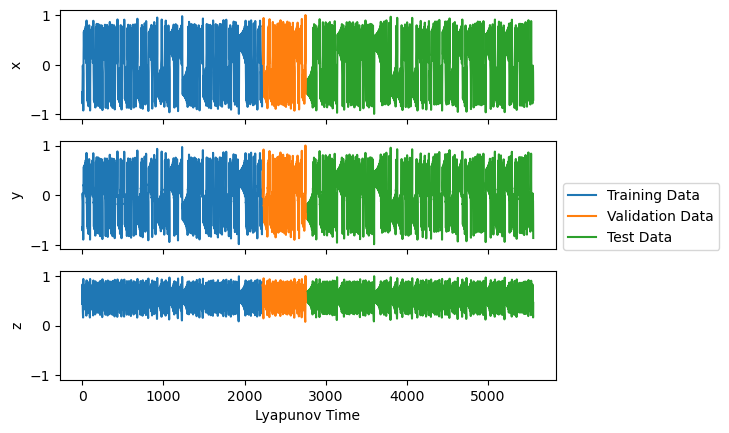

In [6]:
# set sizes
train_size = 20000
valid_size = 5000
test_size = 25000

U_train, U_valid, U_test = split_data(U_rk4, train_size, valid_size, test_size)
time_train, time_valid, time_test = split_data(time_array_lyap, train_size, valid_size, test_size)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(time_train, U_train[:, 0], time_valid, U_valid[:, 0], time_test, U_test[:, 0])
axs[1].plot(time_train, U_train[:, 1], time_valid, U_valid[:, 1], time_test, U_test[:, 1])
axs[0].set_ylabel('x')
axs[1].set_ylabel('y')
axs[2].plot(time_train, U_train[:, 2], label='Training Data')
axs[2].plot(time_valid, U_valid[:, 2], label='Validation Data')
axs[2].plot(time_test, U_test[:, 2], label='Test Data')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Lyapunov Time')
# ax3.set_xlim(0,1)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 1.5))
plt.show()

In [7]:

class SequentialTimeSeriesDataset(Dataset):
    def __init__(self, data, batch_size, window_size):
        self.data = data
        self.batch_size = batch_size
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        # Get a batch of consecutive timesteps
        input_batch = self.data[idx : idx + self.window_size]
        # Get the corresponding label batch (shifted by one time step)
        label_batch = self.data[idx + 1 : idx + self.window_size + 1]
        return input_batch, label_batch

batch_size = 128  # Choose your desired batch size
window_size = 10  # Choose your desired window size
train_dataset = SequentialTimeSeriesDataset(U_train, batch_size, window_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = SequentialTimeSeriesDataset(U_valid, batch_size, window_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


for input, label in train_dataloader:
    print(f"LSTM takes inputs: (batch size, window size, dimension of observations)")
    print(f"Input shape {input.shape} \nLabel shape {label.shape}")
    break

LSTM takes inputs: (batch size, window size, dimension of observations)
Input shape torch.Size([128, 10, 3]) 
Label shape torch.Size([128, 10, 3])


# LSTMs

- LSTMs feature three key gates—input, forget, and output gates—that control the flow of information within the cell. 
- Information of previous cells is kept in both the hidden and cell states. 
  - The hidden state encapsulates long-term information, while the cell state retains short-term information.

<p align="center">
  <img src="lstm_cell.png" alt="LSTM cell" width="30%"/>
</p>




## Open-Loop Mode

The network works in an open-loop configuration during training and validation with the output at each time step depending on current and previous inputs within the time window, and the LSTM’s states are reset to zero at the start of each input sequence.

<p align="center">
  <img src="lstm_open_loop.png" alt="LSTM Open Loop" width="30%"/>
</p>


## Closed-Loop Mode

After training, the network is evaluated on test data with fixed weights and biases, operating in a closed-loop configuration. After a warm-up of one
time window, the network can make long-term predictions in closed loop mode, even if no data is available, and the states of the LSTM are retained across time steps. The network predicts the next time step, and the prediction is used as an input for the next time step, which allows the autonomous evolution of the LSTM.

<p align="center">
  <img src="lstm_closed_loop.png" alt="LSTM Closed Loop" width="30%"/>
</p>


In [8]:
class torchLSTM(nn.Module):
    def __init__(self, hidden_size, observation_dimension, num_layers=1):
        super().__init__()
        self.num_layers=num_layers
        self.hidden_size = hidden_size
        self.observation_dimension = observation_dimension

        # we only use one layer of LSTMs, followed by a dense layer 
        self.lstm = nn.LSTM(input_size=self.observation_dimension, hidden_size=self.hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.observation_dimension)

    
    def forward(self, x):
        x, _ = self.lstm(x.float())
        x = self.linear(x)
        return x
    
    def closed_loop_prediction(self, x, prediction_length):
        batch_size, seq_len, _ = x.size()
        x = x.to(device)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)  # Initial cell state

        output_seq = []
        for t in range(seq_len):
            # Forward pass through LSTM
            out, (h0, c0) = self.lstm(x[:, t:t+1, :], (h0, c0))
            
            # Pass LSTM output through the linear layer to get predictions
            pred = self.linear(out.squeeze(1))
            output_seq.append(pred.unsqueeze(1))
        for t in range(prediction_length):
            # Forward pass through LSTM
            out, (h0, c0) = self.lstm(pred.unsqueeze(1), (h0, c0))
            
            # Pass LSTM output through the linear layer to get predictions
            pred = self.linear(out.squeeze(1))
            output_seq.append(pred.unsqueeze(1))

        # Concatenate the predictions along the sequence dimension
        output_seq = torch.cat(output_seq, dim=1)
        return output_seq

In [9]:
model = torchLSTM(hidden_size=30, observation_dimension=3).cuda().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-8 )
loss_fn = nn.MSELoss()
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
torchLSTM                                --
├─LSTM: 1-1                              4,200
├─Linear: 1-2                            93
Total params: 4,293
Trainable params: 4,293
Non-trainable params: 0

In [11]:
n_epochs = 100

train_losses = []  # List to store training losses
valid_losses = []  # List to store validation losses

for epoch in range(n_epochs):
    # Training
    model.train()
    start_time = time.time()
    loss_tracker_train = 0
    
    for n_batches, [X_batch, y_batch] in enumerate(train_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch) 
        
        loss_tracker_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    loss_tracker_valid = 0
    
    with torch.no_grad():
        for n_batches, [X_batch_valid, y_batch_valid] in enumerate(valid_dataloader):
            X_batch_valid = X_batch_valid.to(device)
            y_batch_valid = y_batch_valid.to(device)
            
            y_pred_valid = model(X_batch_valid)
            loss_valid = loss_fn(y_pred_valid, y_batch_valid)
            
            loss_tracker_valid += loss_valid.item()
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Store losses
    train_losses.append(loss_tracker_train / (n_batches + 1))
    valid_losses.append(loss_tracker_valid / (n_batches + 1))
    
    # Print training and validation results
    print(f"Epoch {epoch + 1} |  {epoch_duration:.2f} seconds | Train MSE: {loss_tracker_train / (n_batches + 1):.4e} | "
          f"Validation MSE: {loss_tracker_valid / (n_batches + 1):.4e} | ")

Epoch 1 |  1.90 seconds | Train MSE: 4.8637e-04 | Validation MSE: 1.0479e-04 | 
Epoch 2 |  1.88 seconds | Train MSE: 3.5230e-04 | Validation MSE: 7.5953e-05 | 
Epoch 3 |  1.92 seconds | Train MSE: 2.5503e-04 | Validation MSE: 5.5220e-05 | 
Epoch 4 |  1.81 seconds | Train MSE: 1.8470e-04 | Validation MSE: 4.0758e-05 | 
Epoch 5 |  1.91 seconds | Train MSE: 1.3472e-04 | Validation MSE: 2.9861e-05 | 
Epoch 6 |  1.89 seconds | Train MSE: 1.0017e-04 | Validation MSE: 2.2575e-05 | 
Epoch 7 |  1.86 seconds | Train MSE: 7.7099e-05 | Validation MSE: 1.8174e-05 | 
Epoch 8 |  1.84 seconds | Train MSE: 6.2133e-05 | Validation MSE: 1.4970e-05 | 
Epoch 9 |  1.91 seconds | Train MSE: 5.2075e-05 | Validation MSE: 1.3079e-05 | 
Epoch 10 |  1.88 seconds | Train MSE: 4.5256e-05 | Validation MSE: 1.1345e-05 | 
Epoch 11 |  1.88 seconds | Train MSE: 4.0286e-05 | Validation MSE: 1.0219e-05 | 
Epoch 12 |  1.86 seconds | Train MSE: 3.6576e-05 | Validation MSE: 9.5039e-06 | 
Epoch 13 |  1.85 seconds | Train MSE:

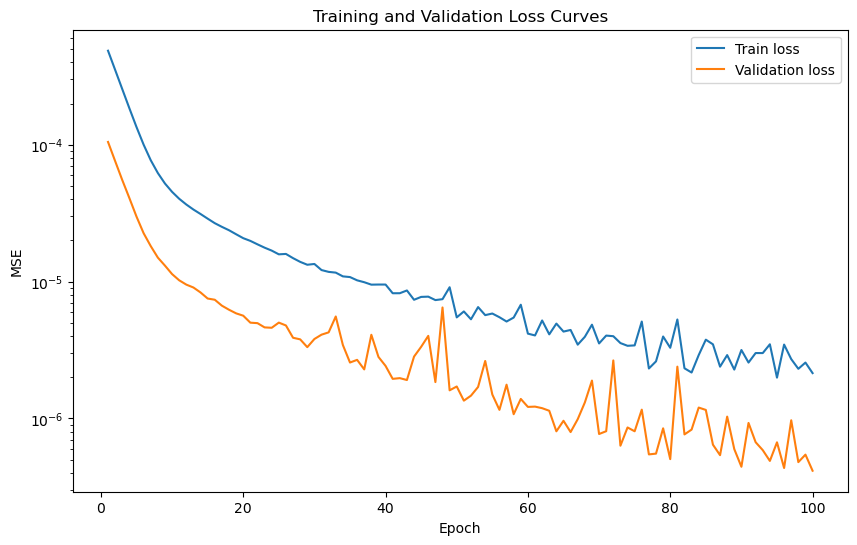

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss Curves')
plt.yscale("log")
plt.legend()
plt.show()

## Prediction on the test data in closed-loop

We compare two different predictions on the test data:
#### 1. Short-term prediction:
- This demonstrates how long the short-term prediction of the LSTM corresponds to the reference solution. Because the systems is chaotic, any two close trajectories will seperate after a given time. We expect a prediction of at least 1 Lyapunov time. 

#### 2. Long-term prediction:
- This demonstrates how statistical prediction of the LSTM and allows us to understand if the network reproduces the long-term behaviour (sometimes referred as climate) of the chaotic system. 


In [13]:
# take a random time window from the test data
N_start = np.random.randint(len(U_test)-10000)
single_window = torch.reshape(torch.from_numpy(U_test[N_start:N_start+window_size, :]), shape=(1, window_size, 3)).to(device)
prediction = model.closed_loop_prediction(single_window, prediction_length=1000)

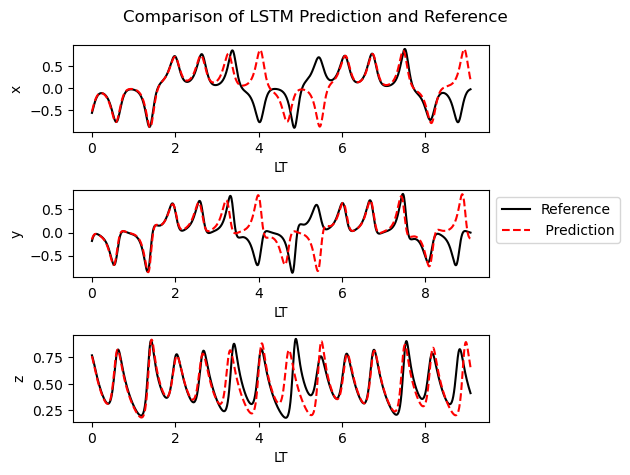

In [14]:
N_plot = min(10 * N_lyap,prediction.shape[1], U_rk4[N_start:, :].shape[0])
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap
prediction_plot = prediction.cpu().detach().numpy()[0]
reference_plot = U_test[N_start:N_start+prediction.shape[1], :] 
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1)

# Plot U_test for the first feature
axes[0].plot(time_steps[:N_plot], reference_plot[:N_plot, 0], color='black', label='Reference')
axes[0].plot(time_steps[:N_plot], prediction_plot[:N_plot, 0], color='red', linestyle='dashed', label=' Prediction')
axes[0].set_ylabel("x")
axes[0].set_xlabel("LT")

# Plot U_test for the second feature
axes[1].plot(time_steps, reference_plot[:N_plot, 1], color='black', label='Reference')
axes[1].plot(time_steps, prediction_plot[:N_plot, 1], color='red', linestyle='dashed', label=' Prediction')
axes[1].set_ylabel("y")
axes[1].set_xlabel("LT")
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot prediction and U_test for the third feature
axes[2].plot(time_steps[:N_plot], reference_plot[:N_plot, 2], color='black', label='Reference')
axes[2].plot(time_steps[:N_plot], prediction_plot[:N_plot, 2], color='red', linestyle='dashed', label='LSTM Prediction')
axes[2].set_ylabel("z")
axes[2].set_xlabel("LT")

# Add a title for the entire figure
fig.suptitle("Comparison of LSTM Prediction and Reference")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()

In [15]:

def stats_lorenz63(prediction_length, single_window):
    prediction = model.closed_loop_prediction(single_window, prediction_length=prediction_length)
    Ys_t = prediction.cpu().detach().numpy()[0]

        
    # Calculate the integral of the kde between 10 and 20:
    xmin, xmax = -1,1 
    n_bins = 50
    x = np.linspace(xmin,xmax,n_bins)
    
    fig, axs = plt.subplots(1,3)
    
    fig.suptitle('Probability Density Function (PDF)')

    fig.set_figheight(4)
    fig.set_figwidth(16)

    for i in range(dim):
        signal = U_test[:prediction_length,i]
        signal_p  = Ys_t[:prediction_length,i] #predicted closed loop
        
        kde = stats.gaussian_kde(signal)
        kde_p = stats.gaussian_kde(signal_p)
            
        axs[i].plot(x,kde(x),color='black', label='Reference')
        axs[i].plot(x,kde_p(x), color='red', linestyle='dashed', label='LSTM Prediction')
        axs[i].set_ylabel('PDF')

    axs[0].set_xlabel('$x$')
    axs[1].set_xlabel('$y$')
    axs[2].set_xlabel('$z$')
    plt.legend()    
    
    return(Ys_t)


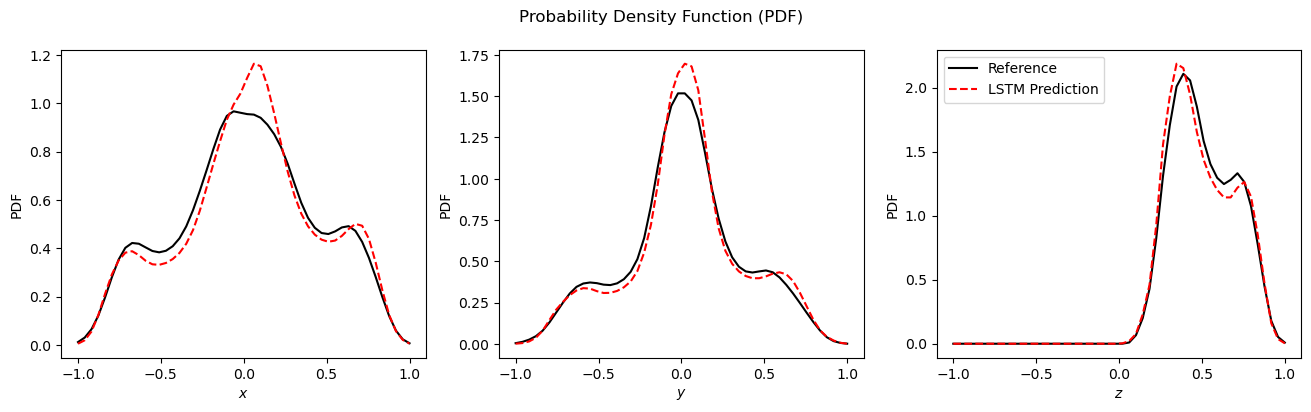

In [16]:
prediction_length = 500*N_lyap # How many lyapunov times to generate for statistical predictions
U_pred_lstm = stats_lorenz63(prediction_length, single_window)
plt.show()

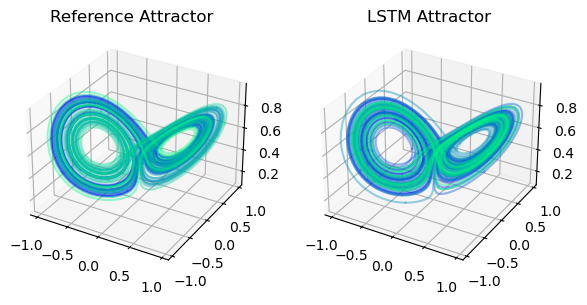

In [17]:

fig = plt.figure(figsize=(12, 5))

# First subplot for U_rk4
ax1 = fig.add_subplot(121, projection='3d')
fig.subplots_adjust(left=0, right=0.55, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
n = len(U_rk4[:10000])
s = 100
cmap = plt.cm.winter  # winter

for i in range(0, n - s, s):
    ax1.plot(U_rk4[i:i+s+1, 0], U_rk4[i:i+s+1, 1], U_rk4[i:i+s+1, 2], color=cmap(i/n), alpha=0.4)

ax1.set_title('Reference Attractor ')

# Second subplot for U_pred_lstm
ax2 = fig.add_subplot(122, projection='3d', sharex=ax1, sharey=ax1, sharez=ax1)
fig.subplots_adjust(left=0.55, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
for i in range(0, n - s, s):
    ax2.plot(U_pred_lstm[i:i+s+1, 0], U_pred_lstm[i:i+s+1, 1], U_pred_lstm[i:i+s+1, 2], color=cmap(i/n), alpha=0.4)

ax2.set_title('LSTM Attractor')

plt.show()